## Introduction
This Jupyter Notebook demonstrates a comprehensive example of using PySpark for machine learning. We will compare the performance of various machine learning models on a flight delay prediction task. The code is organized into the following sections:

Setting Up the Environment: Import necessary libraries and set up the Spark session.

Loading and Preprocessing Data: Load the flight dataset, preprocess it by converting distances and creating a label for delayed flights.

Indexing Categorical Columns: Convert categorical features into numerical indices using StringIndexer.

Assembling Feature Vector: Combine individual features into a single feature vector using VectorAssembler.

Model Training and Evaluation: Train and evaluate multiple machine learning models.


In [11]:

# Import necessary libraries
import numpy as np
import pandas as pd
import os
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.ml import Pipeline

from pyspark.sql.functions import round
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, \
    LogisticRegression, GBTClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Create a Spark session
spark = SparkSession.builder \
    .master('local[*]') \
    .appName('ML with PySpark') \
    .getOrCreate()


## Loading and Preprocessing Data
Next, we load the flight dataset, remove unnecessary columns, and preprocess the data by converting miles to kilometers and creating a binary label for delayed flights.

In [12]:
# Load the flight dataset and preprocess it
flights_data = spark.read.csv('data/flights-larger.csv',
                              sep=',',
                              header=True,
                              inferSchema=True,
                              nullValue='NA')

# Remove unnecessary columns
flights_data = flights_data.drop('flight')
flights_data = flights_data.dropna()

# Convert 'mile' to 'km' and create 'label' column
flights_km = flights_data.withColumn('km', round(flights_data.mile * 1.60934, 0)) \
    .drop('mile') \
    .withColumn('label', (flights_data.delay >= 15).cast('integer'))


## Indexing Categorical Columns
Categorical columns need to be converted to numerical indices using the StringIndexer technique.

In [13]:
# Index categorical columns: 'carrier', 'org', and 'label'
indexers = [
    StringIndexer(inputCol=col, outputCol=col + '_idx')
    for col in ['carrier', 'org']
]
indexers.append(StringIndexer(inputCol='label', outputCol='label_idx'))

# Apply StringIndexer using a pipeline
indexer_pipeline = Pipeline(stages=indexers)
flights_indexed = indexer_pipeline.fit(flights_km).transform(flights_km)


## Assembling Feature Vector
We combine selected features into a single feature vector using VectorAssembler.

In [14]:
# Assemble features using VectorAssembler
assembler = VectorAssembler(inputCols=['mon', 'dom', 'dow',
                                       'carrier_idx', 'org_idx', 'km', 'depart', 'duration'],
                            outputCol='features')
flights_assembled = assembler.transform(flights_indexed)


## Model Training and Evaluation
We define a list of classifiers, train each model, and evaluate its performance using accuracy and AUC metrics.

In [15]:
# Split the data into training and testing sets
flights_train, flights_test = flights_assembled.randomSplit([0.8, 0.2], seed=42)

# Define a list of classifiers
classifiers = [
    DecisionTreeClassifier(labelCol='label_idx', featuresCol='features'),
    RandomForestClassifier(labelCol='label_idx', featuresCol='features'),
    LogisticRegression(labelCol='label_idx', featuresCol='features'),
    GBTClassifier(labelCol='label_idx', featuresCol='features'),
    NaiveBayes(labelCol='label_idx', featuresCol='features')
]

# Train and evaluate each classifier
results = []
for classifier in classifiers:
    model = classifier.fit(flights_train)
    predictions = model.transform(flights_test)

    evaluator_acc = MulticlassClassificationEvaluator(labelCol='label_idx', metricName='accuracy')
    accuracy = evaluator_acc.evaluate(predictions)

    evaluator_auc = BinaryClassificationEvaluator(labelCol='label_idx', metricName='areaUnderROC')
    auc = evaluator_auc.evaluate(predictions)

    # Confusion matrix
    y_true = predictions.select('label_idx').collect()
    y_pred = predictions.select('prediction').collect()
    cm = confusion_matrix(y_true, y_pred, labels=list(range(2)))

    results.append((model, accuracy, auc, cm))


Model 1 - DecisionTreeClassificationModel
Accuracy: 0.6337
AUC: 0.4931
Confusion Matrix:
[[16331  9684]
 [ 9251 16424]]



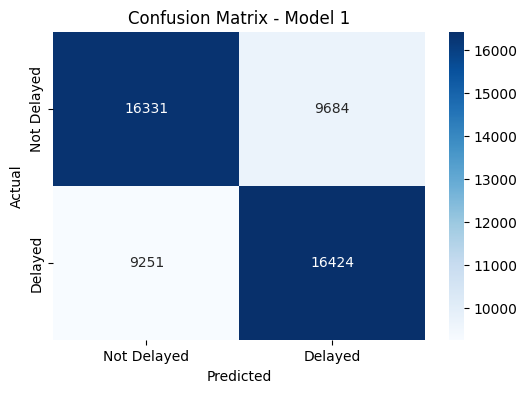

Sample Data:
   mon  dom  dow carrier  org      km  depart  duration  label
0    0    1    2      AA  ORD  2438.0   12.33       240      1
1    0    1    2      AA  ORD  1180.0   16.00       135      1
2    0    1    2      AA  SJC  2314.0   10.33       205      0
3    0    1    2      B6  SJC  4328.0   20.67       322      0
4    0    1    2      UA  ORD  1291.0   16.75       151      1
5    0    2    3      AA  ORD  1091.0    6.83       115      0
6    0    2    3      AA  ORD   975.0    6.92       115      1
7    0    2    3      AA  ORD  2971.0   10.17       285      1
8    0    2    3      AA  ORD  3335.0   14.08       270      1
9    0    2    3      AQ  OGG   161.0   16.17        34      1


Model 2 - RandomForestClassificationModel
Accuracy: 0.6309
AUC: 0.6796
Confusion Matrix:
[[17092  8923]
 [10154 15521]]



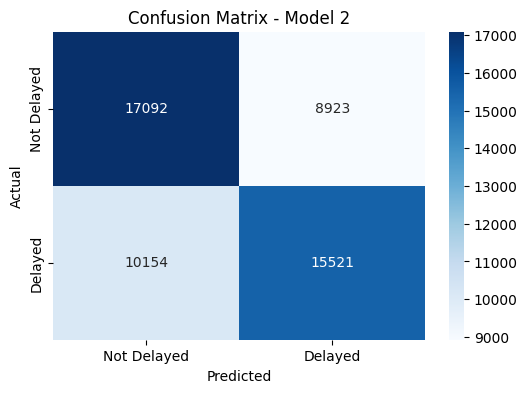

Sample Data:
   mon  dom  dow carrier  org      km  depart  duration  label
0    0    1    2      AA  ORD   649.0    9.67        85      1
1    0    1    2      B6  JFK  1720.0    6.92       185      1
2    0    1    2      OH  JFK   296.0   12.50        78      0
3    0    1    2      UA  ORD  6828.0   10.17       552      1
4    0    1    2      UA  ORD  1357.0   16.57       129      1
5    0    1    2      US  SFO  3695.0   13.00       290      0
6    0    2    3      AA  ORD  2438.0   21.92       225      1
7    0    2    3      OO  ORD   520.0   10.97        78      1
8    0    2    3      UA  SFO  4128.0    8.67       336      1
9    0    2    3      US  SFO  1048.0    9.17       115      0


Model 3 - LogisticRegressionModel
Accuracy: 0.6090
AUC: 0.6485
Confusion Matrix:
[[16544  9471]
 [10741 14934]]



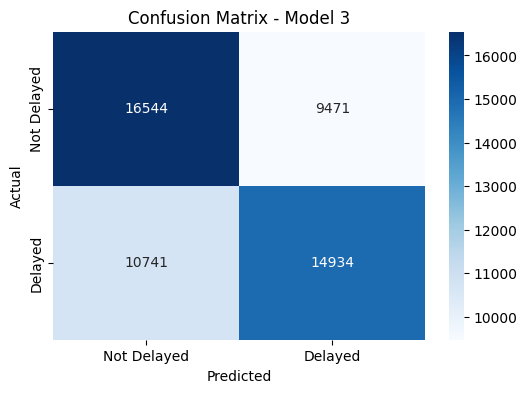

Sample Data:
   mon  dom  dow carrier  org      km  depart  duration  label
0    0    1    2      AA  LGA  1180.0   15.58       160      1
1    0    1    2      AA  LGA  1180.0   20.00       150      1
2    0    1    2      AA  ORD  1180.0    8.75       120      0
3    0    1    2      AA  ORD  1180.0   13.50       130      1
4    0    1    2      OO  ORD   209.0   16.75        51      1
5    0    1    2      UA  ORD  1489.0   14.75       171      1
6    0    1    2      UA  ORD  2773.0   20.25       261      1
7    0    2    3      HA  OGG   161.0   19.92        34      0
8    0    2    3      OO  ORD   253.0   13.62        57      1
9    0    2    3      OO  SFO   254.0   11.83        63      0


Model 4 - GBTClassificationModel
Accuracy: 0.6563
AUC: 0.7206
Confusion Matrix:
[[17699  8316]
 [ 9449 16226]]



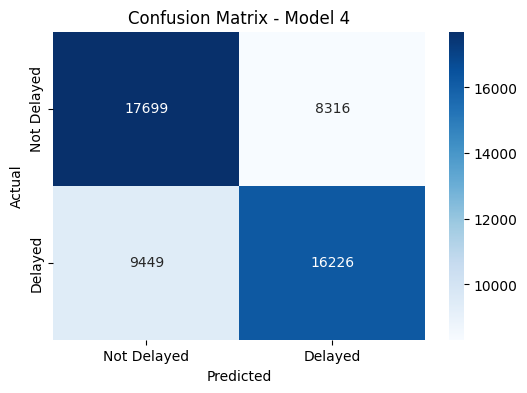

Sample Data:
   mon  dom  dow carrier  org      km  depart  duration  label
0    0    1    2      AA  LGA  2235.0    6.00       240      1
1    0    1    2      AA  ORD  1489.0   12.00       165      1
2    0    1    2      OO  SMF   600.0   12.30        83      0
3    0    1    2      UA  ORD  1157.0    9.00       122      0
4    0    1    2      UA  ORD  1001.0   10.67       113      1
5    0    2    3      AA  ORD  1629.0   13.33       155      0
6    0    2    3      AA  SJC  2314.0    6.42       215      1
7    0    2    3      AQ  OGG   161.0   16.17        34      1
8    0    2    3      B6  JFK   484.0    9.75        95      1
9    0    2    3      B6  JFK   367.0   12.00        75      0


Model 5 - NaiveBayesModel
Accuracy: 0.5571
AUC: 0.5558
Confusion Matrix:
[[12672 13343]
 [ 9550 16125]]



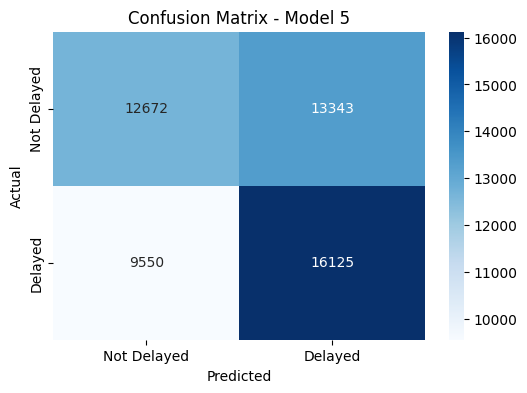

Sample Data:
   mon  dom  dow carrier  org      km  depart  duration  label
0    0    1    2      AA  LGA  1180.0   20.00       150      1
1    0    1    2      AA  ORD  1180.0    8.75       120      0
2    0    1    2      AA  ORD  2770.0   20.08       265      1
3    0    1    2      AQ  OGG   161.0   17.00        34      1
4    0    1    2      B6  JFK  1720.0    6.92       185      1
5    0    2    3      AA  ORD  2808.0   20.58       275      1
6    0    2    3      OH  JFK   465.0   15.50       107      1
7    0    2    3      OO  ORD   669.0   12.50        93      1
8    0    2    3      OO  ORD   196.0   17.75        53      1
9    0    2    3      OO  SJC   496.0   20.48        83      1




In [16]:
# Print the results and plot confusion matrices
for i, (model, accuracy, auc, cm) in enumerate(results):
    print(f"Model {i + 1} - {type(model).__name__}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {auc:.4f}")
    print(f"Confusion Matrix:\n{cm}\n")

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Delayed", "Delayed"], yticklabels=["Not Delayed", "Delayed"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - Model {i + 1}")
    plt.show()
    
    # Display sample data
    print("Sample Data:")
    sample_data = flights_test.select('mon', 'dom', 'dow', 'carrier', 'org', 'km', 'depart', 'duration', 'label').sample(False, 0.1).toPandas()
    print(sample_data.head(10))
    print("\n" + "=" * 40 + "\n")